# Classification_lithops
Based on a train model we make a clasification of raster images thanks to lithops.

### Import libraries

In this section we import the necessary libraries for the realization of our classification

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
import lithops
import joblib
import time
import os
import io

print("Libraries imported succesfully")

Libraries imported succesfully


# Serverless Implementation - Lithops

A execution using lithops where a trained model will be applied to a new image to extract the different classes. This will escalate in several ways:

- Applying the same model to several images in parallel.
- Apply different models to the same image to study which one offers the best results.


Update the **configuration** of lithops through a json file.

In [2]:
import json
config_path = open("/home/jovyan/work/config.txt")
config_read = config_path.read()
config = json.loads(config_read)

Use **map method** to charge **train model** from IBM_COS and **predict** classification for new raster images.

In [3]:
def map_model(obj, ibm_cos):
    print(obj.key + '+' + obj.bucket)
        
    with rasterio.open(obj.data_stream) as src:
        img = src.read() # [:, 150: 200, 150 : 250] - col_off, row_off, width, height
        reshaped_img = reshape_as_image(img)
        shapefile = ibm_cos.get_object(Bucket='geospatial-first-experiment', Key='finalized_model_joblib.sav')['Body']
        loaded_model = joblib.load(io.BytesIO(shapefile.read())) 
        prediction = loaded_model.predict(reshaped_img.reshape(-1, 3))  # for each pixel of our we perform a prediction
        prediction = prediction.reshape(reshaped_img[:, :, 0].shape)

        prediction[prediction == 'superficie_artificial'] = 1
        prediction[prediction == 'bosque_de_coniferas'] = 2
        prediction[prediction == 'bosque_de_frondosas'] = 3
        prediction[prediction == 'zonas_agricolas'] = 4
        prediction[prediction == 'vegetacion_esclerofila'] = 5
        prediction[prediction == 'pastizales_naturales'] = 6
        prediction[prediction == 'matorral_boscoso_de_transicion'] = 7
        prediction[prediction == 'zonas_quedamas'] = 8
        prediction[prediction == 'zonas_humedas'] = 9
        prediction[prediction == 'superficie_agua'] = 10
        prediction = (prediction.astype(int))
        
         # If classified raster images want to be saved in IBM COS: 
        #ibm_cos.put_object(Bucket='testing-lithops', Key=f'classified_raster_{id}.tif', Body=prediction.tobytes())
        
    return prediction

**Iterdata** have the raster images to be parallel clasified.

In [4]:
iterdata  = ['cos://large-scale-process/valenciana_624000.0-4192000.0_comunidad_mask.tif',
             'cos://large-scale-process/valenciana_624000.0-4192000.0_comunidad_mask.tif']

In [5]:
if __name__ == "__main__":
    # For Python 3.7 use mavsonnen/lithops-py37:latest + For Python 3.7 use mavsonnen/jdsampe:nogdal
    
    fexec = lithops.FunctionExecutor(config=config,runtime='mavsonnen/jdsampe:nogdal', runtime_memory=2048)
    fexec.map(map_model, iterdata)
    results = fexec.get_result()

Lithops v2.2.5 init for IBM Cloud Functions - Namespace: new-us-east - Region: us_east
ExecutorID 018bec-0 | JobID M000 - Selected Runtime: mavsonnen/jdsampe:nogdal - 2048MB 
ExecutorID 018bec-0 | JobID M000 - Uploading function and data - Total: 1.9KiB
ExecutorID 018bec-0 | JobID M000 - Starting function invocation: map_model() - Total: 2 activations
ExecutorID 018bec-0 - Getting results...


Showing parallel classification **results**.

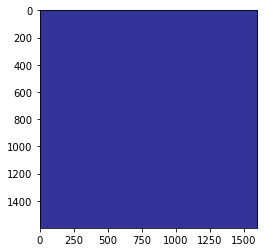

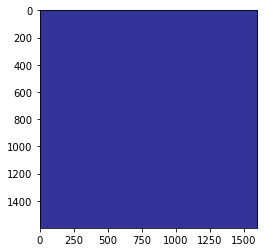

In [6]:
for img in results:
    show(img, cmap='terrain')